# Model for DNA ejection from bacteriophage $\lambda$

In [1]:
# makes plots display inline in notebook interface:
%matplotlib inline 
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

# seaborn for data visualization (not installed by default in Anaconda)
# (filter suppresses a particular Warning issued by matplotlib)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import seaborn as sns

# pandas for handling data
import pandas as pd

# use emcee for MCMC sampling (not installed by default in Anaconda)
import emcee

## The experiment and some sample data

We measure the scattered intensity as a function of time as a virus ejects its DNA.  The intensity decreases when the ejection starts.  The data set, which is available in the github repository, contains four columns:
1. Time: in seconds since the start of the measurement (which starts a little before the ejection begins)
2. Normalized Intensity: Calculated by linearly scaling the backgrounded intensity to 1 before the ejection and 0 after the ejection.
3. Backgrounded Intensity: This is the the intensity of the phage after doing image processing and background division. In this case the background used was the time median of the first 500 frames of the video. The value reported here is the average intensity in a 1.5 pixel radius about the center of the phage.
4. Raw Intensity: This is the raw intensity readout given by the camera that can be used to characterize the shot noise. It is the intensity averaged over a 1.5 pixel radius about the center of the phage

Below is a plot of the normalized intensity as a function of time for one of the ejection events. 

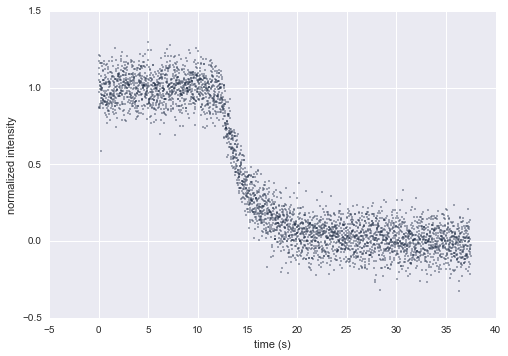

In [2]:
sample_ejection = pd.read_table('./tests/test_data/resultsall_151119chamber3_5_X7_294,347.txt')
sample_ejection.columns = ['time', 'normalized intensity', 'backgrounded intensity', 'raw intensity']
ax = sample_ejection.plot(x='time', y='normalized intensity', kind='scatter', s=1)
ax.set_xlabel('time (s)')

## What we want to infer

We want to infer the friction coefficient of the ejection as a function of the fraction of DNA in the virus.  We also want to know if the ejection "pauses" at any point or reverses itself; in other words, does the velocity decrease smoothly with time or not?  Evidence of "pauses" could be used to support the hypothesis that the DNA undergoes phase transitions during ejection.

## Model for friction coefficient

### Intensity as a function of fraction

Let $\phi(t)$, where $t$ is time, be the fraction of DNA in the virus. $\phi = 1$ before ejection, when the capsid is full, and $\phi=0$ after all the DNA has been ejected.  We assume that the mean value of the intensity $I$ scales linearly with $\phi$: $I_\mathrm{mean} = a\phi(t) + b$.  We have some data to justify this assumption, but it's also the simplest assumption we can make.  Therefore the measured value is
$$I(t) = a\phi(t) + b + \mathrm{noise}$$
where $a$ and $b$ are constants. As described below, we assume our noise is Gaussian with a standard deviation of $\sigma$.

The noise is called "shot noise" and comes from counting a discrete number of photoelectrons, which gives rise to Poisson statistics. The standard deviation is therefore $\sqrt N$ where $N$ is the mean number of electrons detected per frame. Our camera can detect up to 30000 electrons per pixel, and the number of electrons detected is linearly scaled to the 12-bit intensity range (0-4095) for digital readout of the raw intensity ($I_\mathrm{raw}$). So the number of electrons detected in a given pixel is given by $I_\mathrm{raw}\times 30000/4095$. For our intensity measurements we take the mean over a 1.5 pixel radius, so the total number of electrons counted is $N = I_\mathrm{raw}\times30000/4095\times\pi\times1.5^2$. In the sample data set $I_\mathrm{raw}$ varies from $\sim$3000--2900, so $N \approx$ 150000 per data point. Because $N$ is so large, we can assume that the shot noise follows Gaussian statistics with a standard deviation of $\sqrt N$.

For the backgrounded intensity, the standard deviation of the shot noise is $\sigma_\mathrm{bk} = \sqrt N/N = 1/\sqrt N = \left(I_\mathrm{raw} \times 30000/4095\times \pi \times 1.5^2\right)^{-1/2}$. For the sample data this is approximately 0.0026.

For the normalized intensity the standard deviation of the shot noise is $\sigma_\mathrm{norm} = \sigma_\mathrm{bk}/(I_\mathrm{before}-I_\mathrm{after})$, where $I_\mathrm{before}$ and $I_\mathrm{after}$ are the mean intensities before and after ejection. For the sample data $I_\mathrm{before}-I_\mathrm{after} \approx$ 0.025, so $\sigma_\mathrm{norm} \approx$ 0.10.


### Fraction as a function of friction

We can write down an equation of motion for the DNA using Newton's second law:
$$m\frac{d^2x}{dt^2} = F - F_D$$
where $F$ is the ejection force and $F_D$ is the drag force. Because we are at low Reynolds number, we can ignore the acceleration term, leaving us with
$$F = F_D$$

The drag force can be written as the product of a velocity $v$ times a friction coefficient $\gamma$:
$$F_D = \gamma v$$
We define the velocity in terms of the fraction $\phi$:
$$v = -\frac{d\phi}{dt}$$.

Now, we assume that both the ejection force and the drag coefficient are _state functions_ -- that is, they depend only on the fraction of DNA and the buffer conditions: $F = F(\phi)$ and $\gamma = \gamma(\phi)$.  Any dependence on time is implicit. This is the assumption made in ref. [1].  Then we have:
$$\frac{d\phi}{dt} = -\frac{F(\phi)}{\gamma(\phi)}$$. 

Ref. [1] also introduces a model for the ejection force $F(\phi)$. This model is developed in more detail in Ref. [2]. We can use the same model here, so that we can treat $F(\phi)$ as known. The goal then is to infer $\gamma(\phi)$ from the intensity data.  First we need to write $\phi$ in terms of $\gamma$.  To do this, we need to integrate:
$$ \int_\phi^1 \frac{\gamma(\phi')}{F(\phi')} d\phi'= \int_{t_0}^{t} dt' = t-t_0 $$
where $\phi'$ and $t'$ are dummy variables.  Solution for $\phi$ is implicit, but if we know $F(\phi)$ and $\gamma(\phi)$ (for example, we have an MCMC sample of $\gamma(\phi)$), we can construct $\phi(t)$ through numerical integration.


### Final statistical model

The generative model for the data is therefore the combination of the equations from the last two subsections.  We solve for $\phi(t)$ numerically as described at the end of "Fraction as a function of friction", then insert into the equation for $I(t)$ in the equation at the beginning of "Intensity as a function of fraction". 

#### Parameters
The parameters are:
* $a$: slope of 
* $b$: intercept
* $t_0$: start of ejection
* $\gamma(\phi)$

The problem is that the last parameter, $\gamma(\phi)$, is a function and not a scalar.  It is not obvious how to parameterize $\gamma(\phi)$.  But once we figure out a way to infer $\gamma(\phi)$, along with the uncertainty on our estimates, we would like to compare the results across different ejection experiments.  


[1]: Grayson, P.; Han, L.; Winther, T.; Phillips, R. Real-Time Observations of Single Bacteriophage λ DNA Ejections in Vitro. PNAS 2007, 104 (37), 14652–14657.

[2]: Purohit, P. K., Kondev, J., and Phillips, R. “Mechanics of DNA Packaging in Viruses” Proceedings of the National Academy of Sciences 100, no. 6 (2003): 3173–3178. doi:10.1073/pnas.0737893100

  
